Early Spring Data Exploration 
========================

* Frame the problem and look at the big picture
* Get the data



In [21]:
# All of your imports here 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from IPython.display import display
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
import os

In [22]:
# def new_date_features(data):
 ##   data['year'] = data['date'].dt.year
 #   data['month'] = data['date'].dt.month
  #  data['day'] = data['date'].dt.day
 #   return data

def drop_enso_columns(data):

    features_to_drop = [
        'global temperature anomalies',
        'Nino 1+2 SST',
        'Nino 1+2 SST Anomalies',
        'Nino 3 SST',
        'Nino 3 SST Anomalies',
        'Nino 3.4 SST',
        'Nino 3.4 SST Anomalies',
        'Nino 4 SST',
        'Nino 4 SST Anomalies',
        'TNI',
        'PNA',
        'OLR',
        'SOI',
        'Season (2-Month)',
        'Season (3-Month)',
        'Season (12-Month)',
        'ENSO Phase-Intensity'
    ]

    data = data.drop(columns=features_to_drop)

    return data



#### **Merging The Data**

In [23]:
csv_files = [
    'early_spring.csv',
    'phil_pred.csv',
    'soil.csv',
    'weather.csv',
    'ENSO.csv'
]

def process_file(file):
    df = pd.read_csv(file)
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
    elif 'day' in df.columns:
        df['day'] = pd.to_datetime(df['day'])
        df.rename(columns={'day': 'date'}, inplace=True)
    elif 'year' in df.columns:
        df['year'] = pd.to_datetime(df['year'], format='%Y')
        df.rename(columns={'year': 'date'}, inplace=True)
    return df

output_file = 'combined_data.csv'
combined_data = None

for file in csv_files:
    df = process_file(file)
    if combined_data is None:
        combined_data = df
    else:
        combined_data = pd.merge(combined_data, df, on='date', how='outer', suffixes=('', f'_{file.split(".")[0]}'))
    print(f"Processed {file}")

combined_data = combined_data.sort_values(by='date')

combined_data.to_csv(output_file, index=False)

print("\nFirst 5 rows of sorted merged data:")
print(combined_data.head())
print("\nShape of sorted merged data:", combined_data.shape)
print("\nColumns in sorted merged data:")
print(combined_data.columns.tolist())
print("\nMerge and sorting completed. Combined data saved to", output_file)

Processed early_spring.csv
Processed phil_pred.csv
Processed soil.csv
Processed weather.csv
Processed ENSO.csv

First 5 rows of sorted merged data:
        date early_spring prediction  mean_soil_temp  mean_soil_moisture  \
0 1947-01-01        False      False       -3.220000            0.477200   
1 1947-01-02          NaN        NaN       -2.533333            0.498333   
2 1947-01-03          NaN        NaN       -1.733333            0.515000   
3 1947-01-04          NaN        NaN        0.729167            0.496625   
4 1947-01-05          NaN        NaN        0.162500            0.485792   

   min_soil_temp  min_soil_moisture  max_soil_temp  max_soil_moisture  \
0           -4.1              0.475           -1.4              0.480   
1           -3.2              0.478           -1.8              0.518   
2           -2.7              0.504           -0.1              0.519   
3           -0.1              0.489            2.1              0.509   
4           -0.7              

# Frame the Problem and Look at the Big Picture 


1. **Define the objective in business terms:** We want to predict early spring for Groundhog Day (I think right?). We want to be able to estimate if there will be an early spring based on weather and soil data available before April 1st. Being able to predict this accurately can lead to significant financial gains.

2. **How will your solution be used?** It will be used to make a prediction before April 1st each year. The prediction will be based on daily local weather and soil data collected up to that point. This information will be used to make business decisions that can lead to increased profits if the prediction is correct.

3. **What is the current solution?** Currently, there might be traditional methods or less data-driven approaches to predicting early spring. Our solution aims to improve upon these by incorporating more data and using machine learning techniques.

4. **How should you frame this problem?** <mark>This will be a supervised problem where we are predicting whether there will be an early spring or not. We will want this to be a system that can adapt to climate changes over time. Since it's based on weather data, it's unlikely to be gamed or manipulated.</mark> 

5. **How should performance be measured? Is the performance measure aligned with the business objective?** <mark>Since we are When predicting early spring, both small and large mistakes are equally important up to a point. MAE (Mean Absolute Error) works well because it measures all mistakes the same way.</mark>

6. **What would be the minimum performance needed to reach the business objective?** The prediction accuracy should be significantly better than random guessing (50%) to be profitable. Given the profit/loss percentages, an accuracy above 65% would start to be profitable.

7. **What are comparable problems? Can you reuse experience or tools?** <mark>We can use tools and techniques from other binary classification problems in weather prediction or agricultural forecasting. Time series analysis tools will also be valuable given the nature of the data.</mark> 

8. **Is human expertise available?** idk.

9. **How would you solve the problem manually?** <mark>Collect data and compare it against our collected data if it shows similarities with the temperatures and what nought then we can make a educated guess whether it will be a earle spring.</mark>

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** 
    - The local data collected daily is reliable and consistent over the years.
    - Climate change isn't dramatically altering the patterns year over year.
    - The 5-day period before April 1st is the most critical for prediction.


# Get the Data 

1. **List the data you need and how much you need:**
    - Historical weather data (temperature, precipitation, snowfall)
    - Soil temperature and moisture data
    - Early spring occurrence data
    - Groundhog Day predictions (if available)

2. **Find and document where you can get that data:**
    
    - N/A right now

3. **Get access authorizations**: Most of this data should be publicly available, but some soil data might require permission from agricultural departments.

4. **Create a workspace**: This notebook.

5. **Get the data**: 
    - Downloaded early_spring.csv, phil_pred.csv, soil.csv, and weather.csv files
    - These files contain the necessary historical data for our analysis

6. **Convert the data to a format you can easily manipulate**:
   - Data is provided in CSV files, which are easy to use with pandas
   - We've already merged the data into a single combined_data.csv file for easier manipulation

7. **Ensure sensitive information is deleted or protected**: The data appears to be anonymized and doesn't contain sensitive information.

8. **Check the size and type of data (time series, geographical, …)**: <mark>TODO</mark>: Report your information below. At this point, since you don't want to look at the data too closely, this is a quick evaluation about the number of features, the number of samples, and any special considerations about the features such as:
   1. Is it a time series? (Yes, the data is time-based with daily measurements)
   2. Are any of the features not available for the business problem? (We need to ensure we're only using data available before April 1st for predictions)
   3. Which feature(s) will be used as the target/label for the business problem? (The 'early_spring' column from early_spring.csv is likely our target variable)
   4. Should any of the features be stratified during the train/test split to avoid sampling biases? (We might want to stratify by year to ensure we have a good distribution of early spring and non-early spring years in both train and test sets)


#### **Load The Data**

In [24]:
data = pd.read_csv('combined_data.csv') 

#### **Drop Irrelevant Features**

In [25]:
data = drop_enso_columns(data)

#### **Creating New Date Features**

In [26]:
data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' column is in datetime format


In [27]:
dat = data.copy()
dat['year'] = dat.date.dt.year
dat['day_of_year'] = dat.date.dt.day_of_year
dat = dat.drop(columns=['date']).pivot(index='year', columns='day_of_year')
dat.columns = ["_".join(str(x) for x in a) for a in dat.columns.to_flat_index()]

#### **Looking At The Features**

In [39]:
data = dat.copy()
data.shape

(78, 1292)

In [38]:
data.to_csv('final_data.csv', index=False)

In [40]:
empty_columns = data.columns[data.isna().all()].tolist()
for column in empty_columns:
    print(f"Column {column} is empty. Dropping it.")
    data.drop(column, axis=1, inplace=True)

Column early_spring_2 is empty. Dropping it.
Column early_spring_3 is empty. Dropping it.
Column early_spring_4 is empty. Dropping it.
Column early_spring_5 is empty. Dropping it.
Column early_spring_6 is empty. Dropping it.
Column early_spring_7 is empty. Dropping it.
Column early_spring_8 is empty. Dropping it.
Column early_spring_9 is empty. Dropping it.
Column early_spring_10 is empty. Dropping it.
Column early_spring_11 is empty. Dropping it.
Column early_spring_12 is empty. Dropping it.
Column early_spring_13 is empty. Dropping it.
Column early_spring_14 is empty. Dropping it.
Column early_spring_15 is empty. Dropping it.
Column early_spring_16 is empty. Dropping it.
Column early_spring_17 is empty. Dropping it.
Column early_spring_18 is empty. Dropping it.
Column early_spring_19 is empty. Dropping it.
Column early_spring_20 is empty. Dropping it.
Column early_spring_21 is empty. Dropping it.
Column early_spring_22 is empty. Dropping it.
Column early_spring_23 is empty. Dropping 

In [31]:
pd.set_option('display.max_columns', None)

data.head()

,early_spring_1,prediction_1,mean_soil_temp_1,mean_soil_temp_2,mean_soil_temp_3,mean_soil_temp_4,mean_soil_temp_5,mean_soil_temp_6,mean_soil_temp_7,mean_soil_temp_8,mean_soil_temp_9,mean_soil_temp_10,mean_soil_temp_11,mean_soil_temp_12,mean_soil_temp_13,mean_soil_temp_14,mean_soil_temp_15,mean_soil_temp_16,mean_soil_temp_17,mean_soil_temp_18,mean_soil_temp_19,mean_soil_temp_20,mean_soil_temp_21,mean_soil_temp_22,mean_soil_temp_23,mean_soil_temp_24,mean_soil_temp_25,mean_soil_temp_26,mean_soil_temp_27,mean_soil_temp_28,mean_soil_temp_29,mean_soil_temp_30,mean_soil_temp_31,mean_soil_temp_32,mean_soil_temp_33,mean_soil_temp_34,mean_soil_temp_35,mean_soil_temp_36,mean_soil_temp_37,mean_soil_temp_38,mean_soil_temp_39,mean_soil_temp_40,mean_soil_temp_41,mean_soil_temp_42,mean_soil_temp_43,mean_soil_temp_44,mean_soil_temp_45,mean_soil_temp_46,mean_soil_temp_47,mean_soil_temp_48,mean_soil_temp_49,mean_soil_temp_50,mean_soil_temp_51,mean_soil_temp_52,mean_soil_temp_53,mean_soil_temp_54,mean_soil_temp_55,mean_soil_temp_56,mean_soil_moisture_1,mean_soil_moisture_2,mean_soil_moisture_3,mean_soil_moisture_4,mean_soil_moisture_5,mean_soil_moisture_6,mean_soil_moisture_7,mean_soil_moisture_8,mean_soil_moisture_9,mean_soil_moisture_10,mean_soil_moisture_11,mean_soil_moisture_12,mean_soil_moisture_13,mean_soil_moisture_14,mean_soil_moisture_15,mean_soil_moisture_16,mean_soil_moisture_17,mean_soil_moisture_18,mean_soil_moisture_19,mean_soil_moisture_20,mean_soil_moisture_21,mean_soil_moisture_22,mean_soil_moisture_23,mean_soil_moisture_24,mean_soil_moisture_25,mean_soil_moisture_26,mean_soil_moisture_27,mean_soil_moisture_28,mean_soil_moisture_29,mean_soil_moisture_30,mean_soil_moisture_31,mean_soil_moisture_32,mean_soil_moisture_33,mean_soil_moisture_34,mean_soil_moisture_35,mean_soil_moisture_36,mean_soil_moisture_37,mean_soil_moisture_38,mean_soil_moisture_39,mean_soil_moisture_40,mean_soil_moisture_41,mean_soil_moisture_42,mean_soil_moisture_43,mean_soil_moisture_44,mean_soil_moisture_45,mean_soil_moisture_46,mean_soil_moisture_47,mean_soil_moisture_48,mean_soil_moisture_49,mean_soil_moisture_50,mean_soil_moisture_51,mean_soil_moisture_52,mean_soil_moisture_53,mean_soil_moisture_54,mean_soil_moisture_55,mean_soil_moisture_56,min_soil_temp_1,min_soil_temp_2,min_soil_temp_3,min_soil_temp_4,min_soil_temp_5,min_soil_temp_6,min_soil_temp_7,min_soil_temp_8,min_soil_temp_9,min_soil_temp_10,min_soil_temp_11,min_soil_temp_12,min_soil_temp_13,min_soil_temp_14,min_soil_temp_15,min_soil_temp_16,min_soil_temp_17,min_soil_temp_18,min_soil_temp_19,min_soil_temp_20,min_soil_temp_21,min_soil_temp_22,min_soil_temp_23,min_soil_temp_24,min_soil_temp_25,min_soil_temp_26,min_soil_temp_27,min_soil_temp_28,min_soil_temp_29,min_soil_temp_30,min_soil_temp_31,min_soil_temp_32,min_soil_temp_33,min_soil_temp_34,min_soil_temp_35,min_soil_temp_36,min_soil_temp_37,min_soil_temp_38,min_soil_temp_39,min_soil_temp_40,min_soil_temp_41,min_soil_temp_42,min_soil_temp_43,min_soil_temp_44,min_soil_temp_45,min_soil_temp_46,min_soil_temp_47,min_soil_temp_48,min_soil_temp_49,min_soil_temp_50,min_soil_temp_51,min_soil_temp_52,min_soil_temp_53,min_soil_temp_54,min_soil_temp_55,min_soil_temp_56,min_soil_moisture_1,min_soil_moisture_2,min_soil_moisture_3,min_soil_moisture_4,min_soil_moisture_5,min_soil_moisture_6,min_soil_moisture_7,min_soil_moisture_8,min_soil_moisture_9,min_soil_moisture_10,min_soil_moisture_11,min_soil_moisture_12,min_soil_moisture_13,min_soil_moisture_14,min_soil_moisture_15,min_soil_moisture_16,min_soil_moisture_17,min_soil_moisture_18,min_soil_moisture_19,min_soil_moisture_20,min_soil_moisture_21,min_soil_moisture_22,min_soil_moisture_23,min_soil_moisture_24,min_soil_moisture_25,min_soil_moisture_26,min_soil_moisture_27,min_soil_moisture_28,min_soil_moisture_29,min_soil_moisture_30,min_soil_moisture_31,min_soil_moisture_32,min_soil_moisture_33,min_soil_moisture_34,min_soil_moisture_35,min_soil_moisture_36,min_soil_moisture_37,min_soil_moisture_38,min_soil_moisture

#### **Plotting Histograms For All Columns**

#### **Plotting The Mean Soil Temperature Over Time in 2024**

- This graph shows the average soil temperature over two months in early 2024. The temperature changes a lot, going from as low as -5°C to as high as 8°C. You can see two big spikes in late January and early February, which probably happened during warmer days. Overall, the graph shows normal winter-to-early-spring temperature changes, with cold days followed by warmer ones as the season moves toward spring.


#### **Correlation Heatmap**

- From what we can see the correlation matrix reveals strong relationships within soil temperature measures and within soil moisture measures, but weaker connections between temperature and moisture. For example, there's little correlation between soil conditions and time features like year, month, or day.
- This basically means that soil temperature and moisture levels are generally consistent on their own, but they don't always change in sync with each other and don't follow clear seasonal or time-based patterns

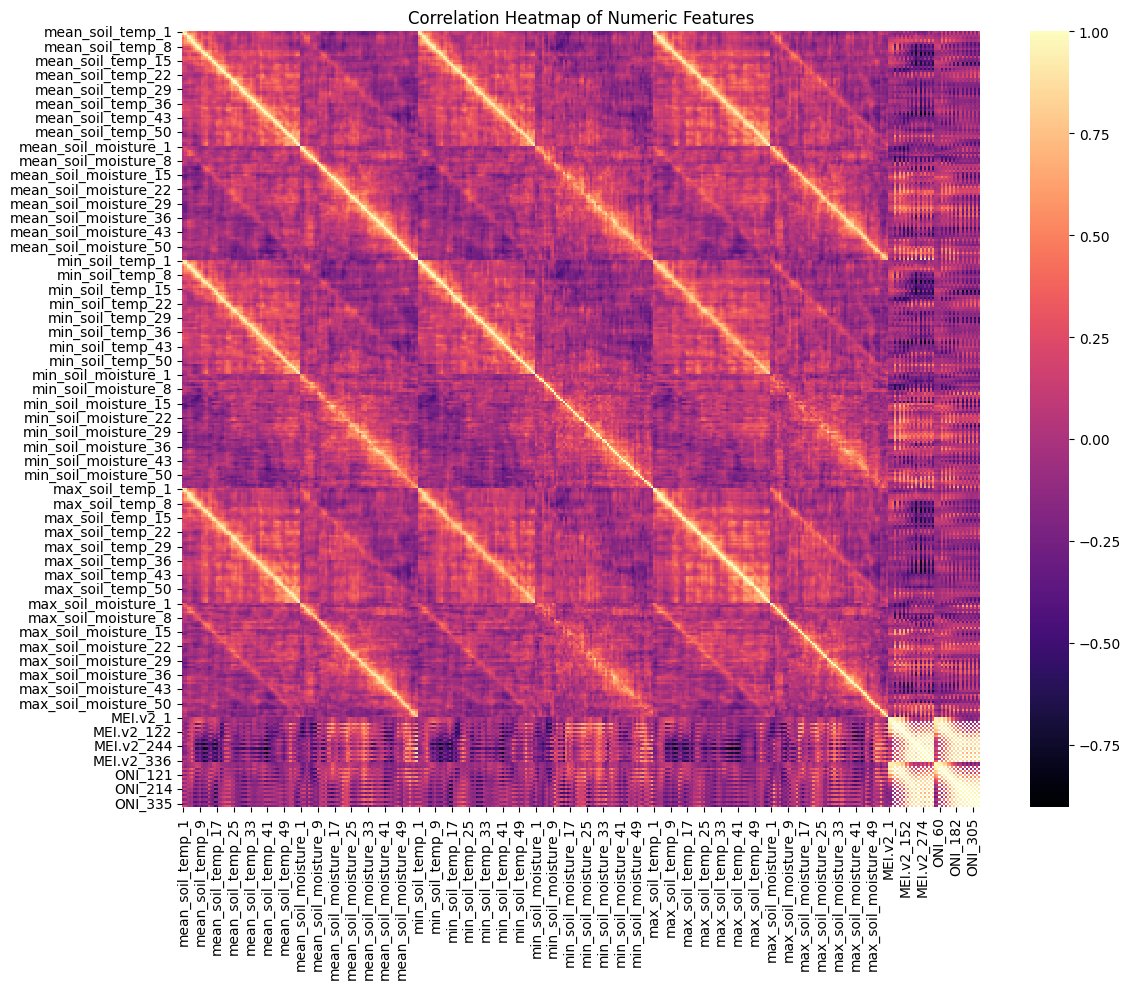

In [32]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='magma')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()

The graph shows soil temperatures from five locations, ranging from -10°C to +12°C over about 80 samples. The lines track closely together, indicating similar temperature changes. Notable spikes occur around samples 5, 50, and 75, with a drop between samples 65 and 70. Overall, soil temperatures are mostly consistent across the area, with minor differences between locations.


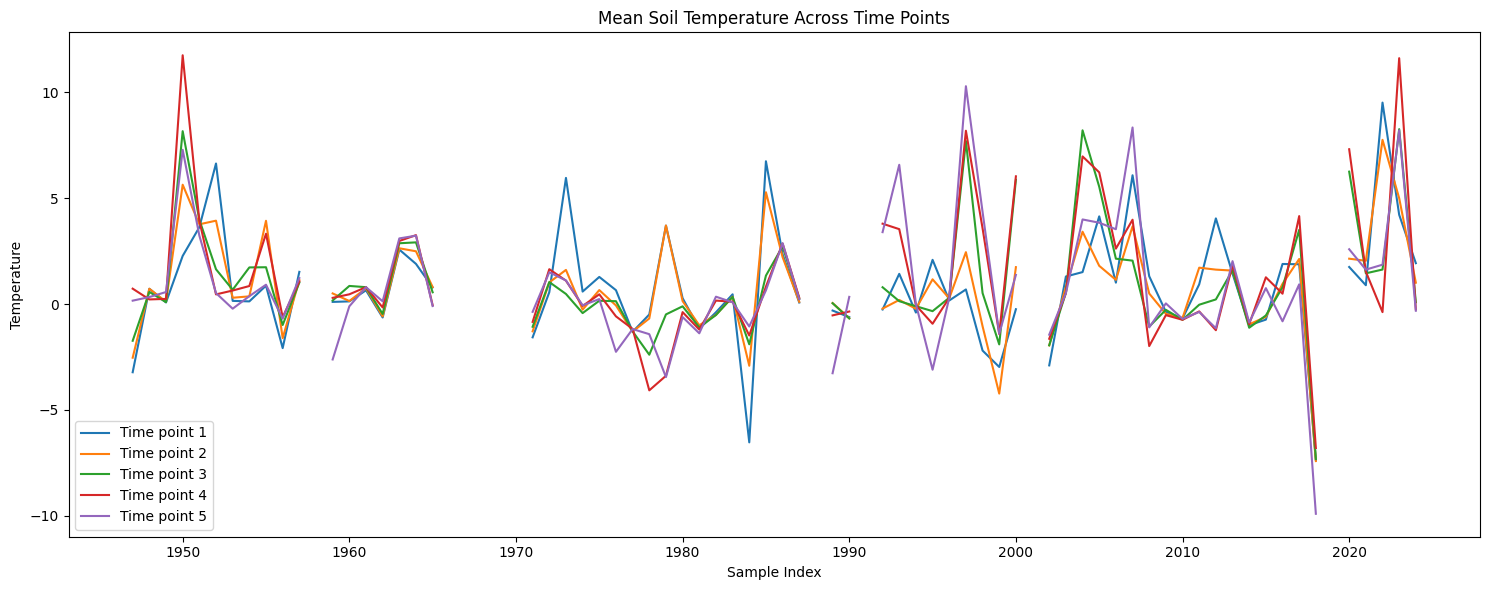

In [33]:
plt.figure(figsize=(15, 6))
soil_temp_cols = [col for col in data.columns if 'soil_temp' in col and 'mean' in col][:5]  # First 5 time points
for col in soil_temp_cols:
    plt.plot(data.index, data[col], label=f'Time point {col.split("_")[-1]}')
plt.title('Mean Soil Temperature Across Time Points')
plt.xlabel('Sample Index')
plt.ylabel('Temperature')
plt.legend()
plt.tight_layout()
plt.show()


This boxplot displays soil moisture levels measured at five different times, ranging from about 0.44 to 0.51. The median moisture level (indicated by the red lines) is stable at around 0.47 across all time points. The similar sizes of the boxes and whiskers suggest that soil moisture is fairly consistent with little variation between measurements.


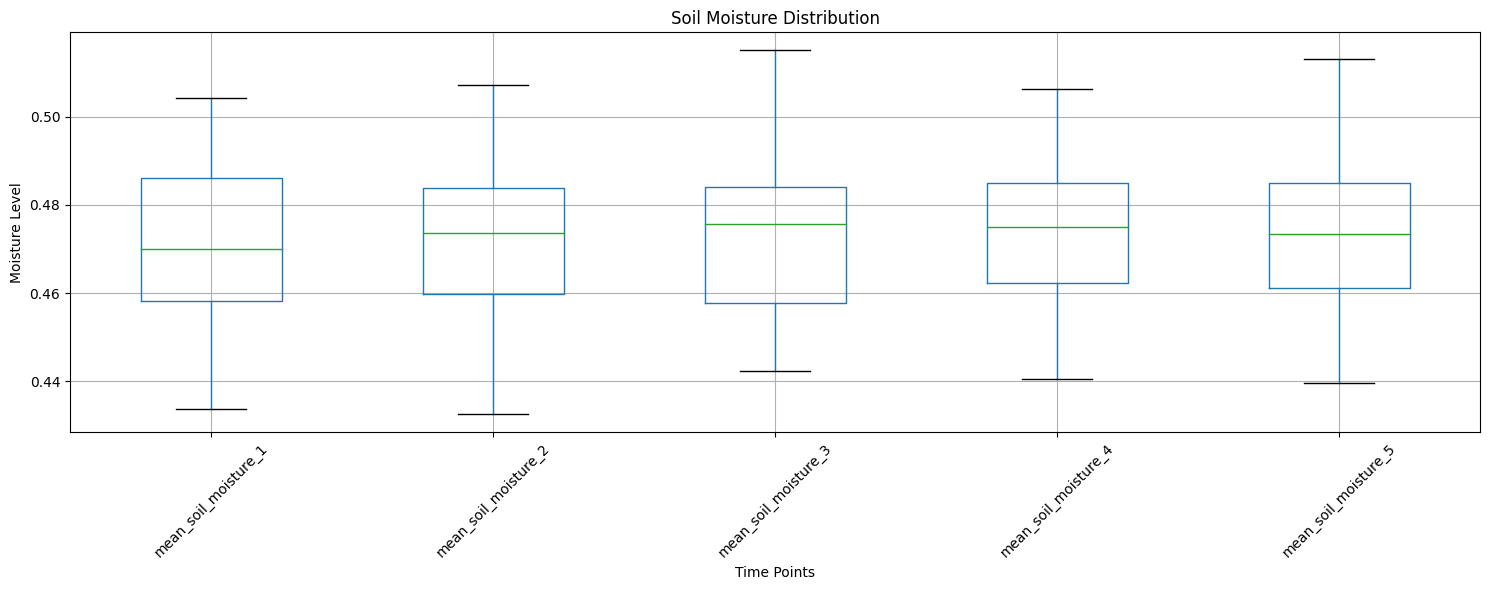

In [34]:
plt.figure(figsize=(15, 6))
moisture_cols = [col for col in data.columns if 'soil_moisture' in col and 'mean' in col][:5]
data[moisture_cols].boxplot()
plt.title('Soil Moisture Distribution')
plt.xlabel('Time Points')
plt.ylabel('Moisture Level')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This scatter plot shows the relationship between soil temperature (x-axis: -7.5°C to 10°C) and soil moisture (y-axis: 0.44 to 0.51), with color intensity indicating data density. Most points cluster around 0°C and 0.47-0.49 moisture levels, but there’s no strong linear relationship, suggesting the two variables are mostly independent.

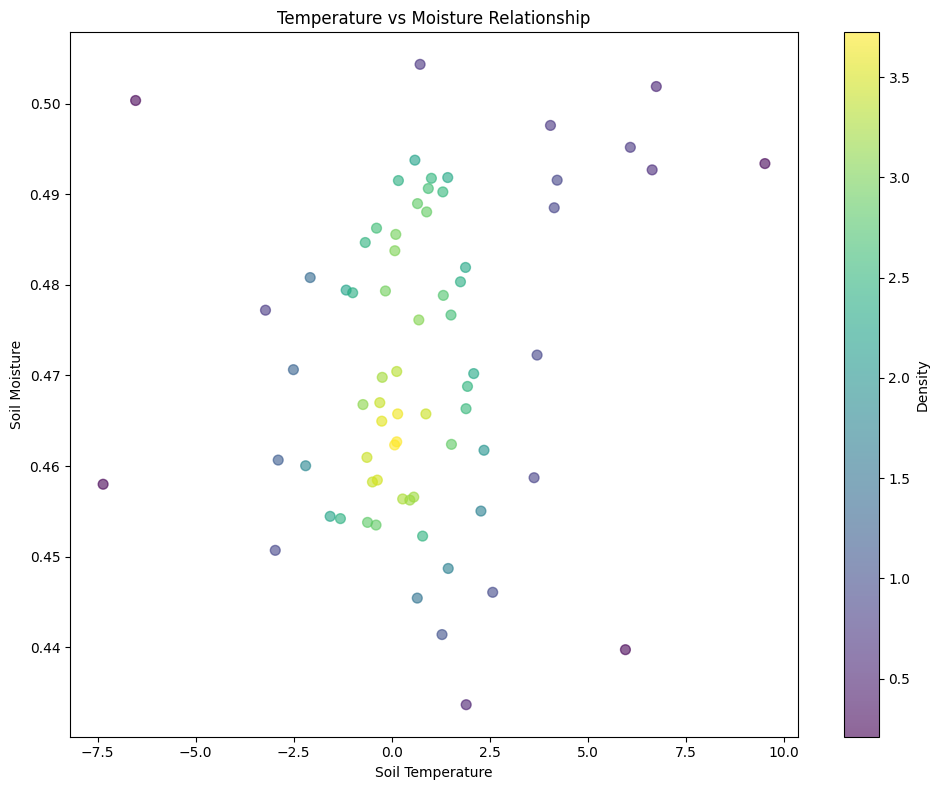

In [35]:
plt.figure(figsize=(10, 8))
if soil_temp_cols and moisture_cols:
    x = data[soil_temp_cols[0]]  # First time point
    y = data[moisture_cols[0]]
    
    # Remove any NaN values
    mask = ~(np.isnan(x) | np.isnan(y))
    x = x[mask]
    y = y[mask]
    
    # Create density scatter plot
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    
    scatter = plt.scatter(x, y, c=z, s=50, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label='Density')
    
plt.title('Temperature vs Moisture Relationship')
plt.xlabel('Soil Temperature')
plt.ylabel('Soil Moisture')
plt.tight_layout()
plt.show()


#### **Splitting The Data**

In [36]:
def split_data():
    train_set, test_set = train_test_split(data, test_size=0.2, random_state=7)
    return train_set, test_set

In [37]:
train_set, test_set = split_data()
data = train_set.copy()